In [1]:
!pip install datasets
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 KB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 4.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer

dataset = load_dataset('SetFit/toxic_conversations', split='train')

print(len(dataset))

README.md:   0%|          | 0.00/507 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/617M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1754874 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

1754874


In [ ]:
import pandas as pd

tokenizer = AutoTokenizer.from_pretrained('gpt2')

def add_token_count(example):
    tokens = tokenizer.tokenize(example["text"], truncation=True, max_length=1024)
    example["token_count"] = len(tokens)
    return example

dataset = dataset.map(add_token_count)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1754874 [00:00<?, ? examples/s]

In [4]:
import pandas as pd

df = dataset.to_pandas()

q1 = df["token_count"].quantile(0.25)
q3 = df["token_count"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Lower bound: -83.0, Upper bound: 197.0


In [5]:
filtered_dataset = dataset.filter(lambda x: lower_bound <= x['token_count'] <= upper_bound)

print(len(filtered_dataset))

Filter:   0%|          | 0/1754874 [00:00<?, ? examples/s]

1649646


In [10]:
import re

def clean_text(example):
    text = example['text']
    text = str(text) if text is not None else ''

    text = re.sub(r"@[A-Za-z0-9_]+", '', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", '', text)
    text = re.sub(r"[^A-Za-z.!?']", ' ', text)
    text = re.sub(r"\r?\n", '', text)
    text = re.sub(r" +", ' ', text)

    text = text.lower()
    example['text'] = text.strip()
    return example

filtered_dataset = filtered_dataset.map(clean_text)
filtered_dataset = filtered_dataset.filter(
    lambda x: len(x['text']) > 0 and len(re.findall(r'[a-zA-Z]', x['text'])) / len(x['text']) > 0.7
)

filtered_dataset = filtered_dataset.filter(
    lambda x: len(x['text'].split()) > 10
)

filtered_dataset = filtered_dataset.map(
    lambda x: {'text': ' '.join(x['text'].split())}
)

print(len(filtered_dataset))

Map:   0%|          | 0/1649646 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1649646 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1632865 [00:00<?, ? examples/s]

Map:   0%|          | 0/1405681 [00:00<?, ? examples/s]

1405681


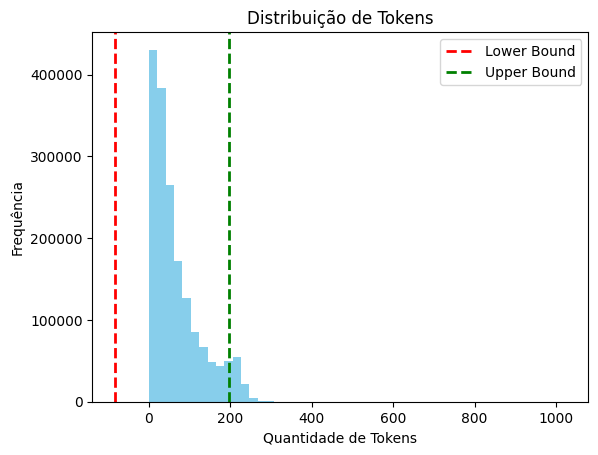

In [12]:
import matplotlib.pyplot as plt

plt.hist(df["token_count"], bins=50, color='skyblue')
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label='Lower Bound')
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label='Upper Bound')
plt.title("Token Distribution")
plt.xlabel("Token Quantity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [13]:
filtered_dataset.to_csv('gpt2-toxic-conversations.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1406 [00:00<?, ?ba/s]

424526881